In [1]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp

from scipy.optimize import minimize

# General imports
import os
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp

# custom module
from susy_qm import calculate_Hamiltonian, create_plots

In [2]:
potential = 'QHO'
#potential = 'AHO'
#potential = 'DW'
cut_off = 16

In [3]:
#calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cut_off, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])
min_eigenvalue = min(eigenvalues.real)

#create qiskit Hamiltonian Pauli string
hamiltonian = SparsePauliOp.from_operator(H)
num_qubits = hamiltonian.num_qubits

In [4]:
num_qubits

5

In [5]:
#Initial params shape
num_layers = 1
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=num_layers, n_wires=num_qubits)

In [6]:
def ansatz(params, wires):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)
    qml.StronglyEntanglingLayers(weights=params, wires=wires, imprimitive=qml.CZ)

In [7]:
# Device
shots = None
dev = qml.device('lightning.qubit', wires=2*num_qubits+1, shots=shots)

@qml.qnode(dev)
def swap_test(params1, params2):

    params1 = pnp.tensor(params1.reshape(params_shape), requires_grad=True)
    params2 = pnp.tensor(params2.reshape(params_shape), requires_grad=True)

    ancilla = 2*num_qubits
    qml.Hadamard(wires=ancilla)

    ansatz(params1, wires=range(num_qubits))
    ansatz(params2, wires=range(num_qubits, 2*num_qubits))

    qml.Barrier()  # added to better visualise the circuit
    for i in range(num_qubits):
        qml.CSWAP(wires=[ancilla, i, num_qubits + i])

    qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)

In [8]:
# Example parameters for testing the swap test
params1 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))
params2 = np.random.uniform(0, 2 * np.pi, size=qml.StronglyEntanglingLayers.shape(1, num_qubits))

# Run the swap test to get the probability of the ancilla being |0>
result = swap_test(params1, params2)

# The overlap is given by 2 * P(ancilla=0) - 1
#overlap = 2 * result[0] - 1

print(qml.draw(swap_test)(params1,params2))
print(f"\nOverlap between the ground state and the ansatz: {result}")

 0: ──Rot(0.01,3.32,5.57)─╭●──────────╭Z──||─╭SWAP────────────────────────────┤       
 1: ──Rot(3.04,0.77,1.03)─╰Z─╭●───────│───||─│─────╭SWAP──────────────────────┤       
 2: ──Rot(2.50,3.76,1.96)────╰Z─╭●────│───||─│─────│─────╭SWAP────────────────┤       
 3: ──Rot(5.33,4.90,5.34)───────╰Z─╭●─│───||─│─────│─────│─────╭SWAP──────────┤       
 4: ──Rot(3.53,0.35,3.18)──────────╰Z─╰●──||─│─────│─────│─────│─────╭SWAP────┤       
 5: ──Rot(0.45,0.80,4.16)─╭●──────────╭Z──||─├SWAP─│─────│─────│─────│────────┤       
 6: ──Rot(4.33,1.58,5.03)─╰Z─╭●───────│───||─│─────├SWAP─│─────│─────│────────┤       
 7: ──Rot(2.26,5.30,3.73)────╰Z─╭●────│───||─│─────│─────├SWAP─│─────│────────┤       
 8: ──Rot(5.46,1.76,3.16)───────╰Z─╭●─│───||─│─────│─────│─────├SWAP─│────────┤       
 9: ──Rot(5.48,2.79,1.74)──────────╰Z─╰●──||─│─────│─────│─────│─────├SWAP────┤       
10: ──H───────────────────────────────────||─╰●────╰●────╰●────╰●────╰●─────H─┤  Probs

Overlap between the ground state and the a

In [29]:
# Device
shots = None
dev2 = qml.device('lightning.qubit', wires=num_qubits, shots=shots)

@qml.qnode(dev2)
def expected_value(params):
    wires = range(num_qubits)
    ansatz(params, wires)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


def loss_f(params):
    global prev_param_list, beta
    energy = expected_value(params)

    penalty = 0

    if len(prev_param_list) != 0:
        for prev_param in prev_param_list:
            overlap =  (beta*swap_test(prev_param, params)[0]) - 1.0
            penalty += (overlap)

    return energy + (penalty)

In [30]:
def callback(xk):
    global iteration_counter, counts, values
    
    current_cost = loss_f(xk)

    iteration_counter += 1
    counts.append(iteration_counter) 
    values.append(current_cost)

In [40]:
vqd_start = datetime.now()

#variables
num_vqd_runs = 4
max_iterations = 10000
beta = 2.0
tolerance = 1e-8

#data arrays
energies = []
prev_param_list = []

all_counts = []
all_values = []
all_overlaps = []

#Initial params
scale = 2.0
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
params = scale*np.pi * pnp.random.random(size=np.prod(params_shape))

for i in range(num_vqd_runs):

    run_start = datetime.now()
    converged = False
    prev_energy = None


    iteration_counter = 0
    counts = []
    values = []
    steps = []

    

    if i % 1 == 0:
        print(f"Run: {i}")


    res = minimize(loss_f,
                   x0=params,
                   method='COBYLA',
                   #constraints=constraints,
                   options={'maxiter': max_iterations, 'tol':tolerance},
                   callback=callback)
    
    all_counts.append(counts)
    all_values.append(values)        

    energies.append(res.fun)
    prev_param_list.append(res.x) 
    print(energies)

    params = res.x

    # Calculate overlap with all previous states
    overlaps = []
    if i > 0:
        for j in range(i):
            overlap = (beta*swap_test(prev_param_list[j], params)[0]) - 1.0
            overlaps.append(overlap)
        all_overlaps.append(overlaps)
        print(f"Overlaps with all previous states for run {i}: {overlaps}")


Run: 0
[5.682989248297358e-17]
Run: 1
[5.682989248297358e-17, 0.9999999982609805]
Overlaps with all previous states for run 1: [0.6984807538707898]
Run: 2
[5.682989248297358e-17, 0.9999999982609805, 1.0000000017390187]
Overlaps with all previous states for run 2: [0.3015192173731558, 0.0]
Run: 3
[5.682989248297358e-17, 0.9999999982609805, 1.0000000017390187, 0.9999999999999984]
Overlaps with all previous states for run 3: [1.1102230246251565e-15, -5.551115123125783e-16, -1.2212453270876722e-15]


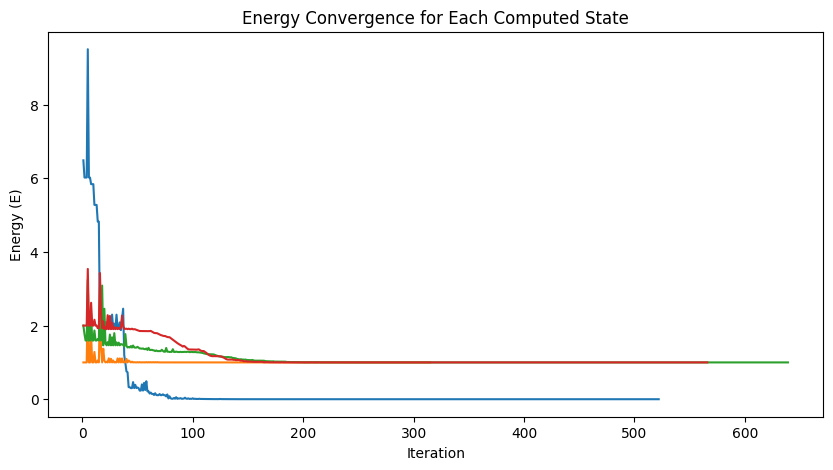

In [41]:
# Plotting each line for different states
plt.figure(figsize=(10, 5))  # Set figure size similar to the uploaded image

for i in range(num_vqd_runs):
    plt.plot(all_counts[i], all_values[i])# label=f"State {i}")

# Set axis labels and title
plt.xlabel("Iteration")
plt.ylabel("Energy (E)")
plt.title("Energy Convergence for Each Computed State")

# Set y-axis to logarithmic scale
#plt.yscale("log")
#plt.ylim(-1.0, 10)

# Display legend
#plt.legend(loc="upper right")

# Show plot
plt.show()
#plt.savefig('VQD-QHO-2')
